Fine tuning a pretrained model to differentiate between sheep and cats.

Heavily influenced by https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [7]:
datasetdir = 'dataset'
import os
os.chdir(datasetdir)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('sheep','cats'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('sheep','cats'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset
    

In [11]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 11616 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


In [9]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [12]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=3,
)

/var/folders/cb/p11211352wv37xf0h3t_mh9c0000gn/T/ipykernel_81334/3528077317.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = full_model.fit_generator(


Epoch 1/3
388/388 [==============================] - 761s 2s/step - loss: 0.0055 - acc: 0.9993 - val_loss: 2.9107e-06 - val_acc: 1.0000
Epoch 2/3
388/388 [==============================] - 801s 2s/step - loss: 2.6773e-07 - acc: 1.0000 - val_loss: 2.1839e-06 - val_acc: 1.0000
Epoch 3/3
388/388 [==============================] - 777s 2s/step - loss: 1.0325e-04 - acc: 1.0000 - val_loss: 2.7676e-10 - val_acc: 1.0000


In [13]:
full_model.save_weights('resnet50.h5')

In [14]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

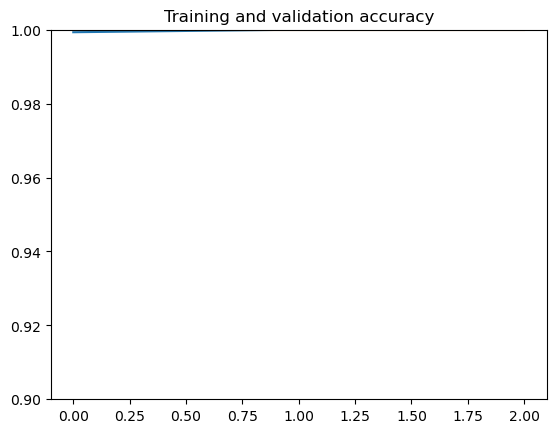

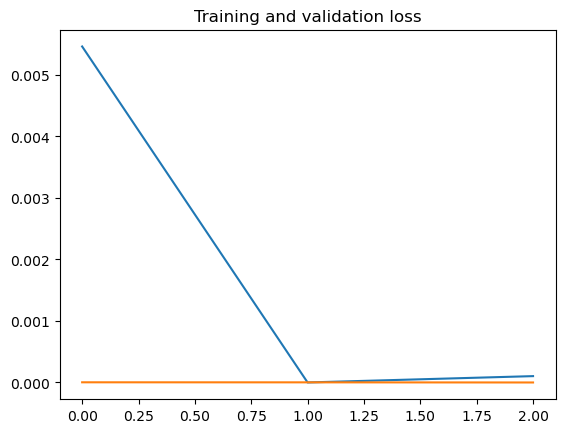

In [15]:
plot_history(history, yrange=(0.9,1))

In [34]:
image = keras.utils 


In [38]:
def evaluate(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    preds = full_model.predict(x)
    # print the probability and category name for the 5 categories 
    # with highest probability: 
    print('Predicted:', decode_predictions(preds, top=5)[0])
    plt.imshow(img)

1/1 [==============================] - 0s 78ms/step
[[0. 1.]]


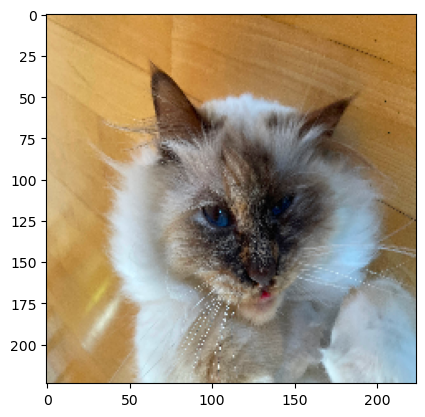

In [82]:
img_path='../tests/b.jpeg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = resnet50.preprocess_input(x)
print(full_model.predict(x))
plt.imshow(img)

The model thinks my cat is a cat. Success!